In [5]:
! huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cre

In [ ]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("imagenet-1k")

In [3]:
from datasets import load_dataset

dataset = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
pip install datasets


In [13]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [15]:
dataset['train'][0].keys()

dict_keys(['image_file_path', 'image', 'labels'])

In [17]:
from PIL import Image
import numpy as np

print("Number of classes:", len(dataset['train'].features['labels'].names))
print("Number of train images:", len(dataset['train']))

widths, heights = [], []
for data in dataset['train']:
    with Image.open(data['image_file_path']) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)
print("Average width:", np.mean(widths))
print("Average height:", np.mean(heights))


Number of classes: 3
Number of train images: 1034
Average width: 500.0
Average height: 500.0


## Visulation

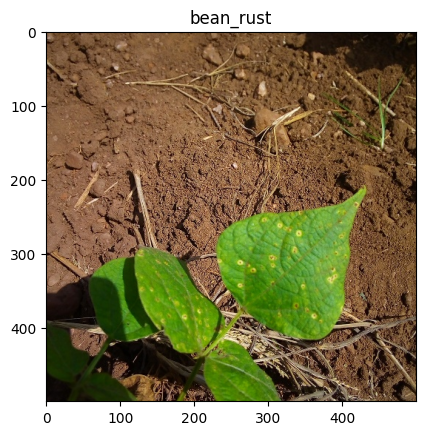

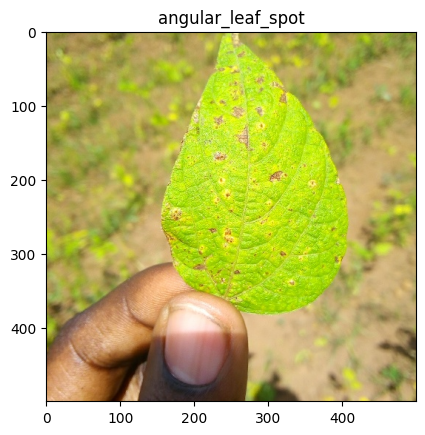

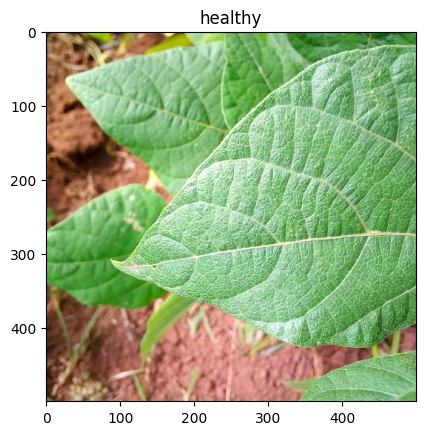

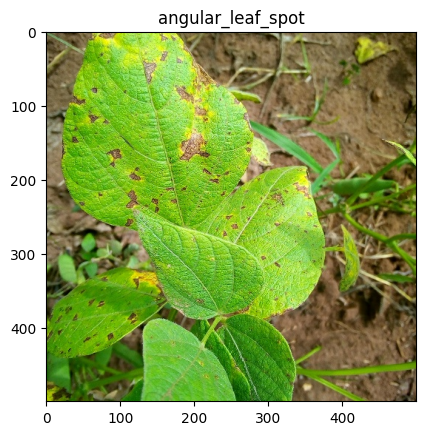

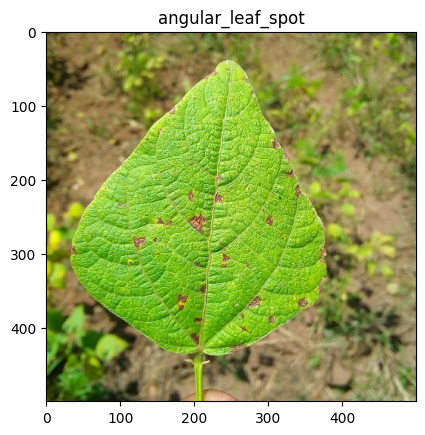

In [20]:
import matplotlib.pyplot as plt
from PIL import Image

sample_data = dataset['train'].shuffle().select(range(5))  # selecting 5 random images
for data in sample_data:
    image = Image.open(data['image_file_path'])
    label = dataset['train'].features['labels'].names[data['labels']]
    plt.imshow(image)
    plt.title(label)
    plt.show()


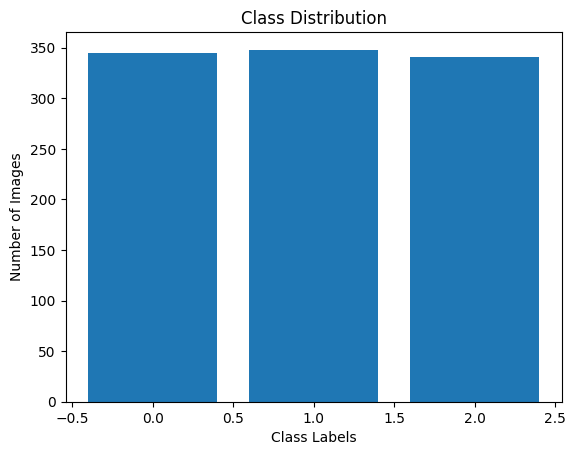

In [21]:
import numpy as np

labels = [data['labels'] for data in dataset['train']]
unique, counts = np.unique(labels, return_counts=True)

plt.bar(unique, counts)
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.show()


## Image Augmentation

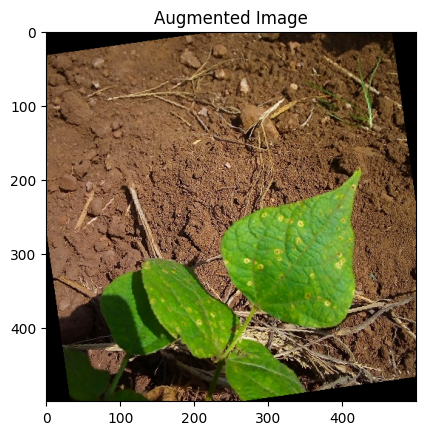

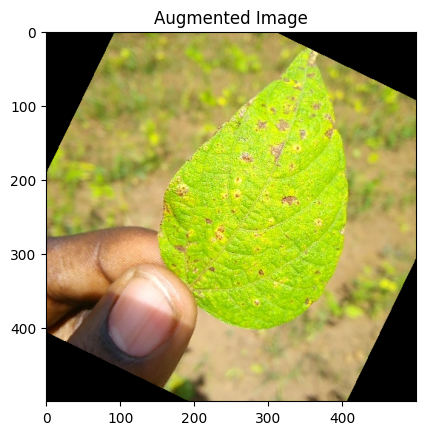

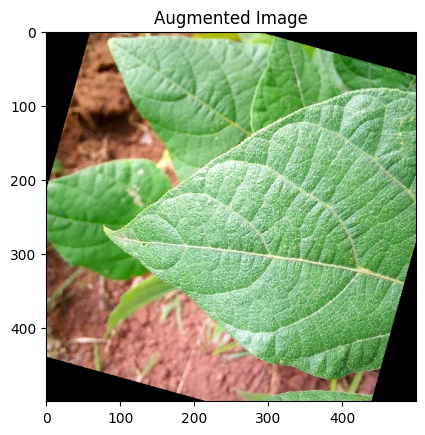

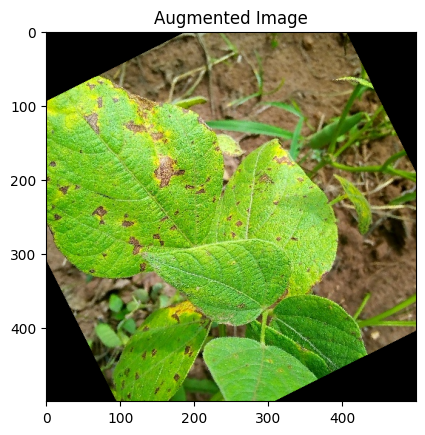

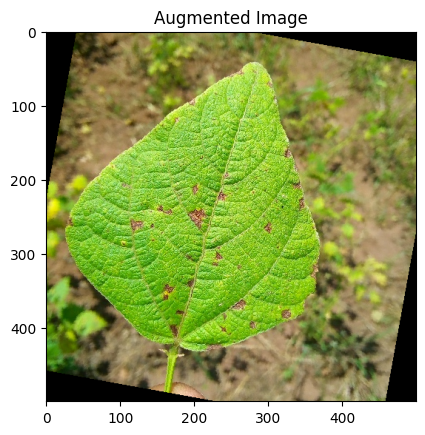

In [23]:
from torchvision.transforms import RandomRotation

transform = RandomRotation(30)
for data in sample_data:
    image = Image.open(data['image_file_path'])
    augmented_image = transform(image)
    plt.imshow(augmented_image)
    plt.title("Augmented Image")
    plt.show()


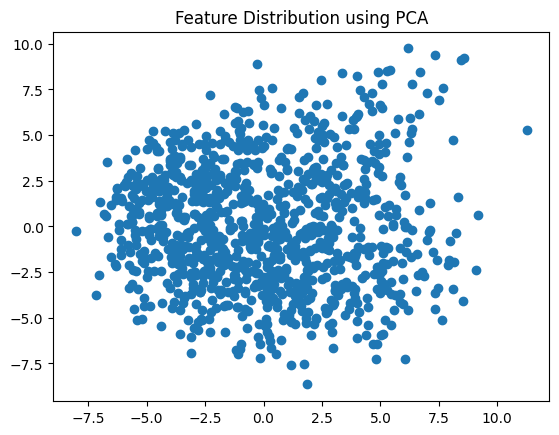

In [26]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt

# Ensure you have the dataset loaded
from datasets import load_dataset
dataset = load_dataset("beans")

# Load a pre-trained ResNet50 model and remove the top layer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50(pretrained=True).to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1])).eval()

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract features for a subset of images
features = []
for data in dataset['train']:
    image = Image.open(data['image_file_path']).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(tensor)
    features.append(feature.cpu().squeeze().numpy())

# Use PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title("Feature Distribution using PCA")
plt.show()



In [31]:
dataset['train'].shape

(1034, 3)

In [33]:
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.6 MB/s eta 0:00:00


In [35]:
import imagehash

hashes = {}
duplicates = []

for data in dataset['train']:
    image = Image.open(data['image_file_path']).convert('RGB')
    h = imagehash.phash(image)
    if h in hashes:
        duplicates.append((data['image_file_path'], hashes[h]))
    else:
        hashes[h] = data['image_file_path']

print(f"Found {len(duplicates)} duplicate pairs.")
for pair in duplicates:
    print("Duplicate pair:", pair)


Found 0 duplicate pairs.
